#Neural Networks - Multi Output Regression

In [14]:
#Mount the google drive connection to our dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tensorflow Notes/datasets/Student_Performance.csv')

In [16]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [17]:
df.shape

(10000, 6)

In [18]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [19]:
df.isna().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

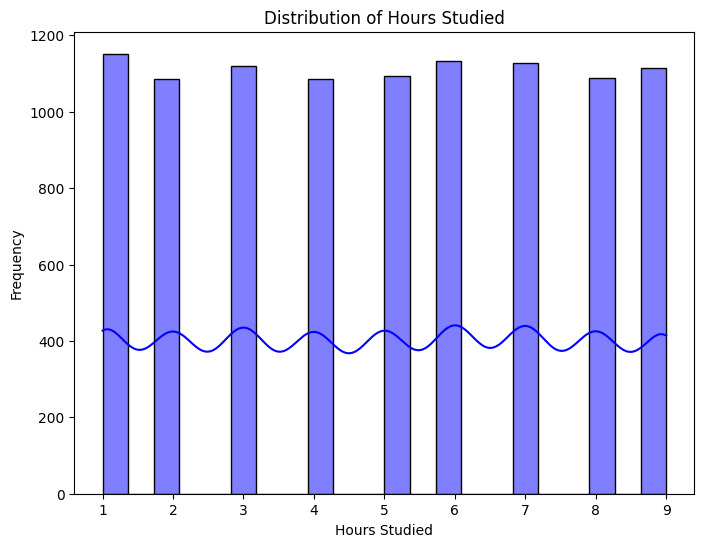

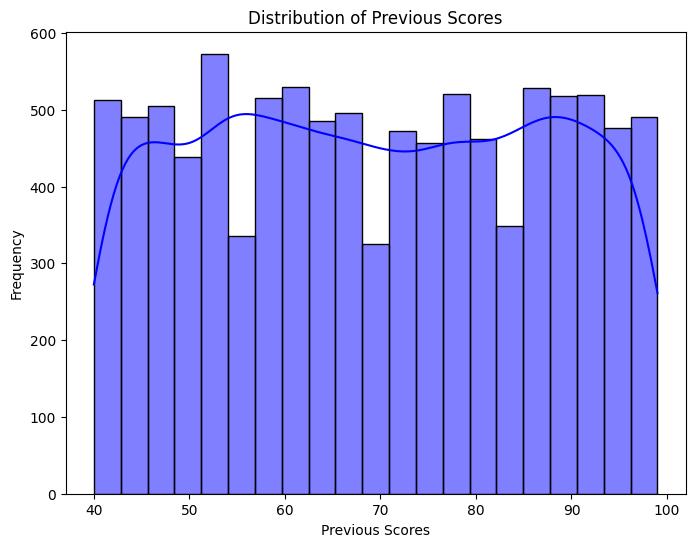

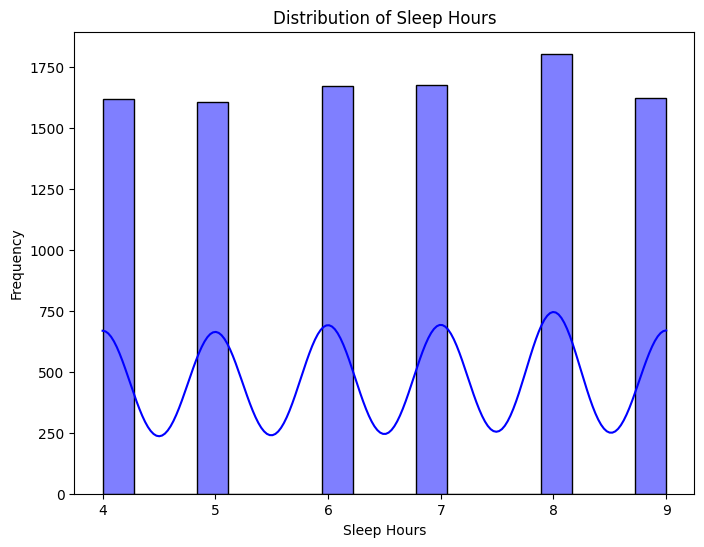

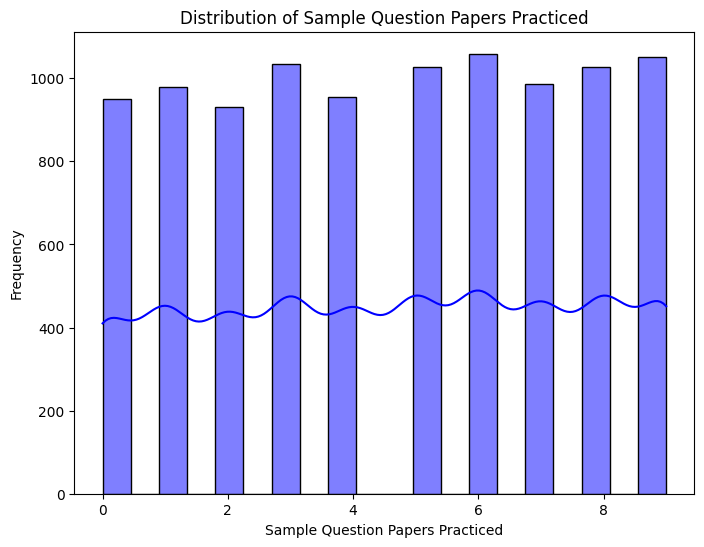

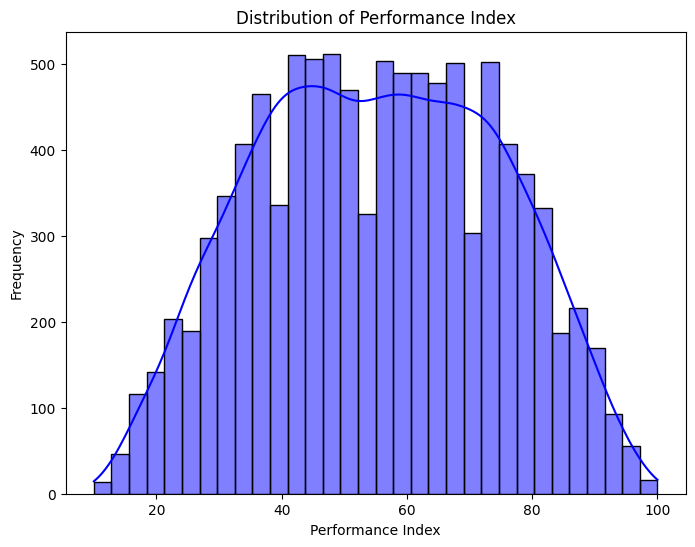

<ipython-input-20-eae17d6a7f85>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[feature], order=df[feature].value_counts().index, palette='Set2')


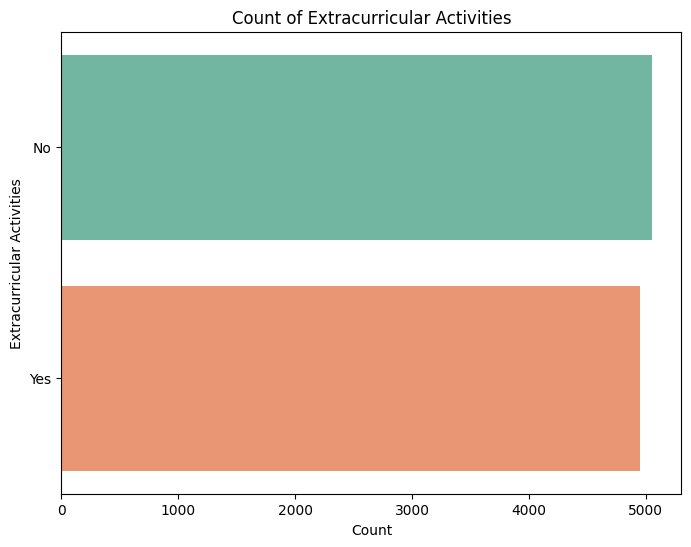

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_charts(df):
  # Numeric features
  numeric_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
  for feature in numeric_features:
      plt.figure(figsize=(8, 6))
      sns.histplot(df[feature], kde=True, color='blue')
      plt.title(f'Distribution of {feature}')
      plt.xlabel(feature)
      plt.ylabel('Frequency')
      plt.show()

  # Categorical features
  categorical_features = [col for col in df.columns if df[col].dtype == 'object']
  for feature in categorical_features:
      plt.figure(figsize=(8, 6))
      sns.countplot(y=df[feature], order=df[feature].value_counts().index, palette='Set2')
      plt.title(f'Count of {feature}')
      plt.xlabel('Count')
      plt.ylabel(feature)
      plt.show()

plot_charts(df)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

# Define the columns
one_hot_cols = ['Extracurricular Activities']
normalized_cols = [col for col in df.columns if col not in one_hot_cols]

# Pipeline for one_hot_cols
one_hot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline for normalized_cols
normalized_pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])

In [22]:
from sklearn.compose import ColumnTransformer

# Combine all pipelines into a single preprocessor
preprocessor = ColumnTransformer([
    ('one_hot', one_hot_pipeline, one_hot_cols),
    ('normalized', normalized_pipeline, normalized_cols)
])

# Now you can fit_transform your data
df_processed = preprocessor.fit_transform(df)

In [23]:
df_processed.shape

(10000, 7)

In [24]:
df_processed

array([[0.        , 1.        , 0.75      , ..., 1.        , 0.11111111,
        0.9       ],
       [1.        , 0.        , 0.375     , ..., 0.        , 0.22222222,
        0.61111111],
       [0.        , 1.        , 0.875     , ..., 0.6       , 0.22222222,
        0.38888889],
       ...,
       [0.        , 1.        , 0.625     , ..., 0.8       , 0.55555556,
        0.71111111],
       [0.        , 1.        , 1.        , ..., 0.6       , 0.        ,
        0.94444444],
       [1.        , 0.        , 0.75      , ..., 0.8       , 0.11111111,
        0.6       ]])

In [25]:
import pandas as pd

# Get unique categories for one-hot encoding
one_hot_categories = [df[col].unique() for col in one_hot_cols]

# Create one-hot feature names
one_hot_feature_names = []
for col, cats in zip(one_hot_cols, one_hot_categories):
    one_hot_feature_names.extend([f"{col}_{cat}" for cat in cats if not pd.isnull(cat)])
normalized_feature_names = normalized_cols

# Combine all feature names
feature_names = one_hot_feature_names + normalized_feature_names

# Create DataFrame with processed data and appropriate column names
df_processed = pd.DataFrame(df_processed, columns=feature_names)

# Print the first few rows to verify
print(df_processed.head())

   Extracurricular Activities_Yes  Extracurricular Activities_No  \
0                             0.0                            1.0   
1                             1.0                            0.0   
2                             0.0                            1.0   
3                             0.0                            1.0   
4                             1.0                            0.0   

   Hours Studied  Previous Scores  Sleep Hours  \
0          0.750         1.000000          1.0   
1          0.375         0.711864          0.0   
2          0.875         0.186441          0.6   
3          0.500         0.203390          0.2   
4          0.750         0.593220          0.8   

   Sample Question Papers Practiced  Performance Index  
0                          0.111111           0.900000  
1                          0.222222           0.611111  
2                          0.222222           0.388889  
3                          0.222222           0.288889  
4    

In [27]:
X = df_processed.drop(["Previous Scores", "Performance Index"], axis=1)
y = df_processed[["Previous Scores", "Performance Index"]]

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(X_train.shape[1],))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)

# Output layer for Previous Scores
output_scores = layers.Dense(1, name='output_scores', activation=None)(x)

# Output layer for Performance Index
output_performance = layers.Dense(1, name='output_performance', activation=None)(x)

# Combine inputs and outputs into a model
model = keras.Model(inputs=inputs, outputs=[output_scores, output_performance])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   384       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 32)                   2080      ['dense[0][0]']               
                                                                                                  
 output_scores (Dense)       (None, 1)                    33        ['dense_1[0][0]']             
                                                                                              

In [31]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
169/169 [==============================] - 5s 7ms/step - loss: 0.1401 - output_scores_loss: 0.0705 - output_performance_loss: 0.0695 - val_loss: 0.1378 - val_output_scores_loss: 0.0694 - val_output_performance_loss: 0.0684
Epoch 2/50
169/169 [==============================] - 0s 2ms/step - loss: 0.1296 - output_scores_loss: 0.0648 - output_performance_loss: 0.0648 - val_loss: 0.1450 - val_output_scores_loss: 0.0731 - val_output_performance_loss: 0.0719
Epoch 3/50
169/169 [==============================] - 1s 5ms/step - loss: 0.1293 - output_scores_loss: 0.0646 - output_performance_loss: 0.0647 - val_loss: 0.1349 - val_output_scores_loss: 0.0677 - val_output_performance_loss: 0.0672
Epoch 4/50
169/169 [==============================] - 0s 2ms/step - loss: 0.1291 - output_scores_loss: 0.0645 - output_performance_loss: 0.0645 - val_loss: 0.1345 - val_output_scores_loss: 0.0675 - val_output_performance_loss: 0.0670
Epoch 5/50
169/169 [==============================] - 0s 2ms/ste

In [33]:
loss = model.evaluate(X_val, y_val)
print("Mean Squared Error on Validation Set (Previous Scores):", loss[1])
print("Mean Squared Error on Validation Set (Performance Index):", loss[2])

63/63 [==============================] - 0s 4ms/step - loss: 0.1317 - output_scores_loss: 0.0660 - output_performance_loss: 0.0657
Mean Squared Error on Validation Set (Previous Scores): 0.06595338881015778
Mean Squared Error on Validation Set (Performance Index): 0.06573657691478729


In [32]:
loss = model.evaluate(X_test, y_test)
print("Mean Squared Error on Test Set (Previous Scores):", loss[1])
print("Mean Squared Error on Test Set (Performance Index):", loss[2])

63/63 [==============================] - 0s 3ms/step - loss: 0.1295 - output_scores_loss: 0.0648 - output_performance_loss: 0.0647
Mean Squared Error on Test Set (Previous Scores): 0.06478123366832733
Mean Squared Error on Test Set (Performance Index): 0.06467337161302567


In [34]:
y_test

,Previous Scores,Performance Index
7072,0.593220,0.477778
6204,0.813559,0.622222
7110,0.983051,0.733333
220,0.491525,0.488889
69,0.796610,0.566667
...,...,...
1156,0.288136,0.400000
1180,0.491525,0.588889
2697,0.033898,0.088889
9018,0.762712,0.611111


In [35]:
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

63/63 [==============================] - 0s 2ms/step


[array([[0.43486947],
        [0.44698584],
        [0.4567576 ],
        ...,
        [0.42540282],
        [0.47376734],
        [0.44131947]], dtype=float32),
 array([[0.43952128],
        [0.44862822],
        [0.45831916],
        ...,
        [0.42631897],
        [0.47108665],
        [0.43879592]], dtype=float32)]